# Case Study - Predict a click Solution

### Bonus Questions are answered at the end of the notebook.

**What I will be doing for this case study:**

* Load data and deal with missing data
* Do basic extrapolatory data analysis
* Remove outliers
* Throw a basic random forest model
* Check the scores.
* Improve model by hyper parameter tuning using grid search
* Apply ensemble modeling
* Run a final model
* Predict on test data
* Submit prediction

I am running multiple iterations so commented code can be ignored as that was for not for the final runs.


## **How I generally approach a Machine Learning Project**



* Frame the problem and look at the big picture.
* Get the data
* Explore the data to get insights.
* Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
* Explore many different models and shortlists the best ones.
* Fine tune your models and combine them into great solution
* Present your solution.

## 1.) Frame the problem

> Based on the data available we need to predict how often a hotel will be clicked by users. This can help us to understand the bigger picture of what are the main reasons behind user clicking on a hotel. How can click through rate be increased? Since Trivago is working on CPC model (I guess so), it is very important that users click on the hotels and book through an advertiser site. 
> 
> It is a supervised learning algorithm and it's an offline model because we don't have to predict number of hits at the time when user is clicking. Instead we are trying to know the reasons behind clicking.

## 2.) Get the data

> We have been provided data for this case study already.  Before doing anything, we need to keep the test data separate and do not see it till the last. In our case, test data is provided separately.

In [201]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys

#Visualization
import matplotlib.pyplot as plt

#Warnings
import warnings
warnings.filterwarnings('ignore')

In [202]:
#Load Data
train_data = pd.read_csv("../input/mytestdataset/train_set.csv")
test_data = pd.read_csv("../input/testset/test_set.csv")

In [203]:
#See few rows to confirm it has been loaded
train_data.head()

,hotel_id,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
0,9.767406e+10,134520.0,70.0,2.0,1199.0,77.0,4.0,861.0,17.550,81.64,18.0,0
1,9.768889e+10,133876.0,67.0,3.0,12585.0,90.0,4.0,4371.0,17.383,189.38,28.0,4
2,9.811544e+10,133732.0,39.0,3.0,23491.0,83.0,3.0,1005.0,16.438,57.63,27.0,44
3,9.824279e+10,43772.0,59.0,8.0,3291.0,73.0,2.0,3084.0,7.000,72.16,2.0,4
4,9.833438e+10,50532.0,66.0,1.0,288.0,80.0,0.0,603.0,12.564,173.25,0.0,10


**Column Definitions**

**hotel_id**: a number uniquely identifying each hotel

**city_id**: describes the city the hotel is located in - Categorical

**content_score**: describes the quality of the content that is provided for the hotel on a scale from 0 (worst) to 100 (best) - Numerical

**n_images**: number of images that are available for the given hotel - numerical

**distance_to_center**: distance (in meters) of the hotel to the nearest city center - numerical

**avg_rating**: average rating of the hotel on a scale from 0 (worst) to 100 (best) - numerical

**stars**: number of stars for the hotel - ordinal feature (categorical but with levels)

**n_reviews**: number of reviews that are available for that hotel - numerical

**avg_rank**: average position the hotel had in the list -numerical

**avg_price**: average price in Euro of the hotel - numerical

**avg_saving_percent**: average saving users achieve on this hotel by using trivago, i.e. the relative difference between the cheapest and most expensive deal for the hotel - numerical

**n_clicks**: the number of clicks the hotel has received in a specific time frame (target variable, unique to the training set) - numerical

In [204]:
#Create a function so that we can see all rows and all columns whenever required instead of defualt ellipses ("...")
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df) 

In [205]:
#Drop hotel_id as it is unique identifier only.
train_data.drop('hotel_id', axis = 1, inplace=True)

#Change city_id to categorical value. As city 1023 is not half in value as city 2046
train_data.city_id = train_data.city_id.astype('category')

In [206]:
#First few steps to check datatypes, number of rows
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396487 entries, 0 to 396486
Data columns (total 11 columns):
city_id               395979 non-null category
content_score         395979 non-null float64
n_images              395978 non-null float64
distance_to_center    395958 non-null float64
avg_rating            286089 non-null float64
stars                 395925 non-null float64
n_reviews             395958 non-null float64
avg_rank              396487 non-null float64
avg_price             396317 non-null float64
avg_saving_percent    396317 non-null float64
n_clicks              396487 non-null int64
dtypes: category(1), float64(9), int64(1)
memory usage: 33.3 MB


In [207]:
#(396487, 11)
train_data.shape

(396487, 11)

# 3.) Explore the data to get insights.

In [208]:
#See the spread of data
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
content_score,395979.0,50.992795,11.563444,7.0,45.000,53.00,59.000,81.0
n_images,395978.0,259.321243,17316.815812,-1.0,0.000,1.00,2.000,2393911.0
distance_to_center,395958.0,16343.827621,275219.956628,0.0,544.000,1516.00,4163.000,18341550.0
avg_rating,286089.0,81.616525,6.025140,34.0,79.000,83.00,86.000,97.0
stars,395925.0,1.159659,1.619713,0.0,0.000,0.00,3.000,5.0
n_reviews,395958.0,913.667419,2432.494160,0.0,0.000,189.00,777.000,283089.0
avg_rank,396487.0,14.694502,5.604578,1.0,11.091,15.00,18.375,100.0
avg_price,396317.0,109.332048,148.198851,4.0,51.050,77.65,120.930,8000.0
avg_saving_percent,396317.0,7.179601,13.081529,0.0,0.000,0.00,10.000,99.0
n_clicks,396487.0,13.781980,123.572896,0.0,0.000,0.00,2.000,13742.0


The data definitely looks erroneous. 

**2.3 million images** for a hotel when average for same is around 259. Also -1 images doen't make sense.

Similarly, **distance to centre is 18 million meters (18000 KM)** when average is around 16KM, 18000 KM means the other part of world, somewhere in pacific ocean.

**n_reviews** has the same problem. 283K reviews when average is 913 reviews.

**Avg price** also looks high for 8000 euros (?) but it can still be a possibility as there are some very expensive hotels.

**n_clicks** with a max of 13472 when mean is 13.78, looks impossible but we should check it. We need to check it from other data in the systme whether it actually gets this clicks?

We can take log of these features later on to deal with skew.

In [209]:
#Let's check some outlier rows.
display_all(train_data[(train_data.n_images == 2393911.0) | 
                       (train_data.distance_to_center == 18341550.0) |
                      (train_data.n_reviews == 283089.0) |
                      (train_data.n_clicks == 13742.0)])

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
211753,8582.0,69.0,11.0,2058.0,86.0,4.0,13404.0,7.381,137.61,21.0,13742
322638,29334.0,62.0,13.0,1940.0,75.0,4.0,283089.0,8.147,93.16,31.0,1534
364534,104086.0,59.0,2393911.0,574.0,85.0,2.0,3090.0,20.000,143.31,10.0,0
372264,139316.0,31.0,0.0,18341550.0,83.0,0.0,198.0,23.636,242.87,0.0,2


In [210]:
#Let's check some data where n_images = -1
display_all(train_data[(train_data.n_images == -1)].head(5))

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
309,40880.0,31.0,-1.0,864.0,NaN,0.0,0.0,16.0,72.00,0.0,0
911,43538.0,31.0,-1.0,3428.0,NaN,0.0,0.0,25.0,77.36,0.0,0
930,46306.0,32.0,-1.0,992.0,NaN,0.0,0.0,10.0,201.51,1.0,0
958,9668.0,37.0,-1.0,169.0,NaN,0.0,0.0,24.0,112.60,0.0,0
1185,146322.0,31.0,-1.0,2779.0,NaN,0.0,0.0,24.0,240.00,0.0,0


**What does negative value for n_images means here? missing data or zero images? **

In [211]:
#Lets check if there are rows with 0 images in the data.
display_all(train_data[(train_data.n_images == 0)].head())

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent,n_clicks
7,138802.0,50.0,0.0,603.0,88.0,0.0,141.0,18.640,49.12,0.0,0
10,344992.0,55.0,0.0,430.0,85.0,0.0,93.0,19.000,89.34,0.0,0
11,54248.0,50.0,0.0,5954.0,80.0,0.0,102.0,15.686,51.19,0.0,2
13,123902.0,50.0,0.0,905.0,87.0,0.0,114.0,9.000,34.80,0.0,0
14,31890.0,56.0,0.0,943.0,83.0,1.0,294.0,11.000,10.37,0.0,0


Since there are images with 0 value as well, I would assume -1 is missing value.

So we need to replace this value by NaN and then in next step we will replace it by median of whole population.

In [212]:
train_data.n_images = train_data.n_images.replace(-1.0, np.nan)

In [213]:
#Let's check the missing data as well.

def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

check_missing_data(train_data)

,Total,Percent
avg_rating,110398,27.844040
n_images,3870,0.976072
stars,562,0.141745
n_reviews,529,0.133422
distance_to_center,529,0.133422
content_score,508,0.128125
city_id,508,0.128125
avg_saving_percent,170,0.042877
avg_price,170,0.042877
n_clicks,0,0.000000


Generally, it is better to ignore any variable which have more than 15% of missing values. avg_rating has ~28% of missing data.

Should we leave it? Generally yes, but average rating should be an important feature. From my own experience, I choose to click on the hotels with more average_rating. Also, almost all the portals have functionality of sorting hotels on avg_rating. This means, more the rating, more are the chances of clicking one.

This is where we would need an insight from an expert, or extra data.

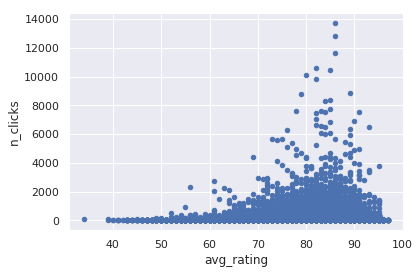

In [214]:
#Let's quickly check, what's the relation b/w avg_rating and n_clicks.

#scatter plot avg_ratings/n_clicks
var = 'avg_rating'
data = pd.concat([train_data['n_clicks'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='n_clicks')

***Something to ponder: ***

> We can see above that, if we leave outliers, n_clicks increases with avg_ratings but then decrease after 85 avg_ratings. What could be the reason? Are hotels with more than 85% avg_rating expensive and user avoid to click them? 

> In other words, is there a correlation b/w avg_rating and price, or other variables? We will plot a correlation map later on.


Let's work on missing values now.

Let us first find the median of datsets' features and impute missing with that. Median because mean could introduce bias because of outliers.

**Thinking cap on..** I am really not sure about median as well, though. While I think more about it, I am going ahead with median

In [215]:
train_data = train_data.fillna(train_data.median())

In [216]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
content_score,396487.0,50.995367,11.556257,7.0,45.000,53.00,59.000,81.0
n_images,396487.0,259.006570,17305.698987,0.0,0.000,1.00,2.000,2393911.0
distance_to_center,396487.0,16324.044070,275036.825782,0.0,545.000,1516.00,4158.000,18341550.0
avg_rating,396487.0,82.001740,5.155463,34.0,80.000,83.00,85.000,97.0
stars,396487.0,1.158015,1.619152,0.0,0.000,0.00,3.000,5.0
n_reviews,396487.0,912.700555,2431.014796,0.0,0.000,189.00,777.000,283089.0
avg_rank,396487.0,14.694502,5.604578,1.0,11.091,15.00,18.375,100.0
avg_price,396487.0,109.318464,148.168528,4.0,51.060,77.65,120.910,8000.0
avg_saving_percent,396487.0,7.176523,13.079568,0.0,0.000,0.00,10.000,99.0
n_clicks,396487.0,13.781980,123.572896,0.0,0.000,0.00,2.000,13742.0


In [217]:
#Check missing data for all features.

#Arguments: Dataframe 

def check_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data =pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

check_missing_data(train_data)

,Total,Percent
n_clicks,0,0.0
avg_saving_percent,0,0.0
avg_price,0,0.0
avg_rank,0,0.0
n_reviews,0,0.0
stars,0,0.0
avg_rating,0,0.0
distance_to_center,0,0.0
n_images,0,0.0
content_score,0,0.0


# 4.) Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.

Let us first check the target variable itself.

In [218]:
train_data['n_clicks'].describe()

count    396487.000000
mean         13.781980
std         123.572896
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max       13742.000000
Name: n_clicks, dtype: float64

Data is very skewed. 75% of the values are less than 2 but max is too high at 13742. 

First let us remove the obvious outliers and then We should take log of n_clicks to deal with skewness.

In [219]:
#Replace number_of_click with its log value to deal with skewness. 
#For that, we first replace 0 with NaN and then Nan back to zero

train_data['n_clicks'] = np.log(train_data[['n_clicks']].replace(0, np.nan)).replace(np.nan, 0)

In [220]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
content_score,396487.0,50.995367,11.556257,7.0,45.000,53.00,59.000000,8.100000e+01
n_images,396487.0,259.006570,17305.698987,0.0,0.000,1.00,2.000000,2.393911e+06
distance_to_center,396487.0,16324.044070,275036.825782,0.0,545.000,1516.00,4158.000000,1.834155e+07
avg_rating,396487.0,82.001740,5.155463,34.0,80.000,83.00,85.000000,9.700000e+01
stars,396487.0,1.158015,1.619152,0.0,0.000,0.00,3.000000,5.000000e+00
n_reviews,396487.0,912.700555,2431.014796,0.0,0.000,189.00,777.000000,2.830890e+05
avg_rank,396487.0,14.694502,5.604578,1.0,11.091,15.00,18.375000,1.000000e+02
avg_price,396487.0,109.318464,148.168528,4.0,51.060,77.65,120.910000,8.000000e+03
avg_saving_percent,396487.0,7.176523,13.079568,0.0,0.000,0.00,10.000000,9.900000e+01
n_clicks,396487.0,0.699162,1.287034,0.0,0.000,0.00,0.693147,9.528212e+00


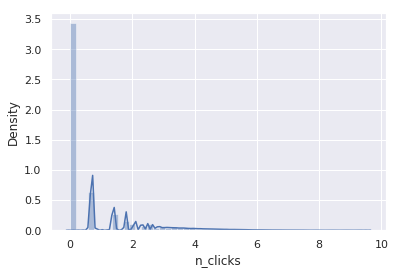

In [221]:
import seaborn as sns
sns.distplot(train_data['n_clicks'])
plt.ylabel("Density")
plt.show()

Make little more sense now

### Let's find out relationship of n_clicks with other numerical variables.

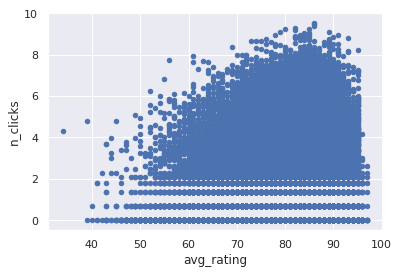

In [222]:
#scatter plot avg_ratings/n_clicks
var = 'avg_rating'
data = pd.concat([train_data['n_clicks'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='n_clicks')

As expected, n_clicks increased with increase of avg_ratings but then starts decreasing after 85 or more rating.

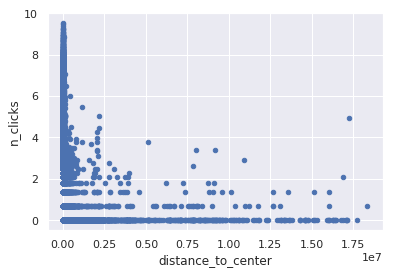

In [223]:
#scatter plot distance_to_center/n_clicks
var = 'distance_to_center'
data = pd.concat([train_data['n_clicks'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='n_clicks')

The number of clicks decreases as distance_to_center decreases which makes sense.

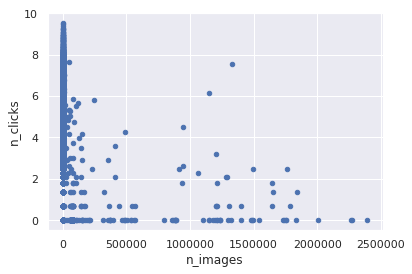

In [224]:
#scatter plot n_images/n_clicks
var = 'n_images'
data = pd.concat([train_data['n_clicks'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='n_clicks')

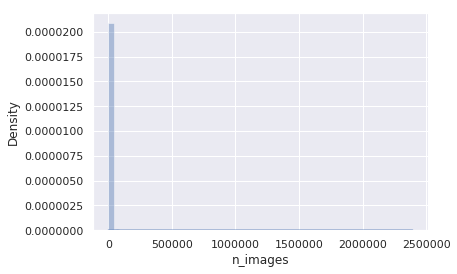

In [225]:
import seaborn as sns
sns.distplot(train_data['n_images'])
plt.ylabel("Density")
plt.show()

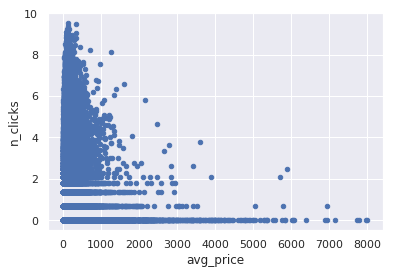

In [226]:
#scatter plot avg_price/n_clicks
var = 'avg_price'
data = pd.concat([train_data['n_clicks'], train_data[var]], axis=1)
data.plot.scatter(x=var, y='n_clicks');

# OUT "LIARS"!!

I am going to use interquartile range formula and delete all the rows where there are more than 1 outliers in the row. We will keep all the values b/w Inter quartile range (1.5 times up/down of IQR(Q3-Q1))

This again need an expertise on data, are the outliers really outliers, wrong data or we should keep them?

In [227]:
#Outlier Detection

from collections import Counter

def get_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        #1st Quartile
        Q1 = np.percentile(df[col],25)
        #3rd Quartile
        Q3 = np.percentile(df[col],75)
        #Inter-Quartile Range
        IQR = Q3 - Q1
        
        #Outliers Range        
        outliers_boundary = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        list_outlier_cols = df[(df[col] < Q1 - outliers_boundary) | (df[col] > Q3 + outliers_boundary)].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(list_outlier_cols)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    more_than_two_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return more_than_two_outliers   

#Function takes 3 parameters - DataFrame,number of outliers you want to check in an observations, feature columns 
Outliers_to_drop = get_outliers(train_data, 2, ["n_images","distance_to_center","n_reviews"])

In [228]:
train_data.loc[Outliers_to_drop].shape

(516, 11)

If I consider 1 outlier per row as the criterion, I have to remove 94 rows which is very very less % of the original data.

In [229]:
#Drop outliers
train_data = train_data.drop(Outliers_to_drop, axis = 0)

In [230]:
#Let's see the spread once more

train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
content_score,395971.0,50.981264,11.554461,7.0,45.000,53.00,59.000000,8.100000e+01
n_images,395971.0,230.888032,16199.498497,0.0,0.000,1.00,2.000000,2.393911e+06
distance_to_center,395971.0,16324.399400,275215.138483,0.0,544.000,1516.00,4139.000000,1.834155e+07
avg_rating,395971.0,82.004829,5.150130,34.0,80.000,83.00,85.000000,9.700000e+01
stars,395971.0,1.155072,1.617610,0.0,0.000,0.00,3.000000,5.000000e+00
n_reviews,395971.0,903.717113,2400.191689,0.0,0.000,189.00,771.000000,2.830890e+05
avg_rank,395971.0,14.695955,5.606660,1.0,11.088,15.00,18.382000,1.000000e+02
avg_price,395971.0,109.302747,148.236742,4.0,51.040,77.64,120.870000,8.000000e+03
avg_saving_percent,395971.0,7.148170,13.052368,0.0,0.000,0.00,10.000000,9.900000e+01
n_clicks,395971.0,0.696883,1.284250,0.0,0.000,0.00,0.693147,9.528212e+00


In [231]:
#Let's drop the data points where n_clicks are above 1000. But first check how many rows we are going to drop.

#This was in the first iteration. In this iteration we have taken log of n_clicks. So it doesn't matter now.

# train_data_check = train_data[train_data.n_clicks > 1000]
# print(train_data_check.n_clicks.count())

In [232]:
#We are dropping 3336 rows out of 396487 rows which is less than 1% of the training data.
#Again for the first iteration.
# train_data = train_data[train_data.n_clicks <=1000]
# print(train_data.shape)

In [233]:
#Change city_code to Categoy define categories.
train_data['city_id'] = train_data['city_id'].astype('category').cat.codes

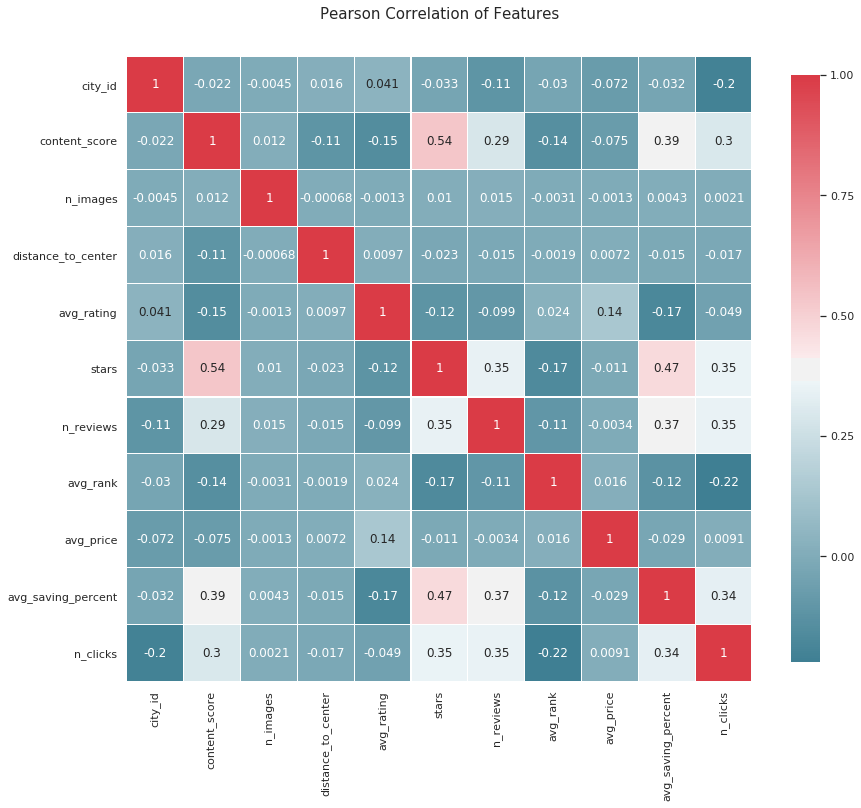

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_data)

We can see many red squares now other than diagonals. There is high correlation b/w 

* stars and content_score
* n_reviews and content_score
* stars and n_images
* n_reviews and n_images.

Which features we should keep?

We will check scores with correlated variables and after dropping them.

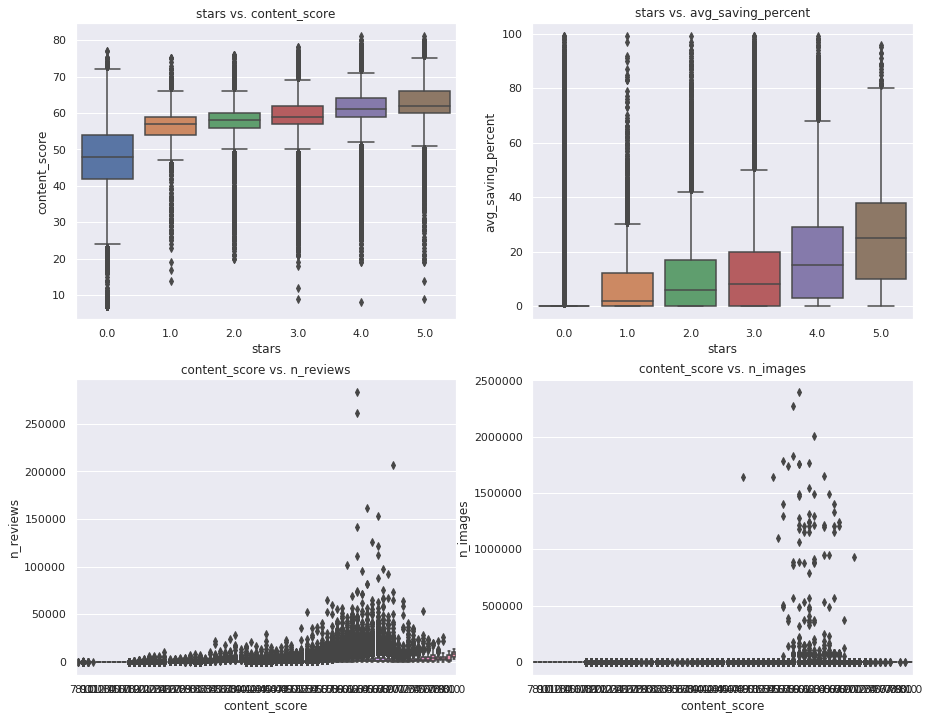

In [235]:
#Let's check few of them on box plot.

plt.figure(figsize=(15,12))

plt.subplot(2, 2, 1)
sns.boxplot(x="stars", y="content_score", data=train_data)
plt.title("stars vs. content_score")

plt.subplot(2, 2, 2)
sns.boxplot(x="stars", y="avg_saving_percent", data=train_data)
plt.title("stars vs. avg_saving_percent")


plt.subplot(2, 2, 3)
sns.boxplot(x="content_score", y="n_reviews", data=train_data)
plt.title("content_score vs. n_reviews")

plt.subplot(2, 2, 4)
sns.boxplot(x="content_score", y="n_images", data=train_data)
plt.title("content_score vs. n_images")

plt.show()

We can easily see there is a correlation.

In [236]:
import gc
gc.collect()

83655

Let's plot a pairplot to check if there is any relationship b/w variables which is easily identifiable but we missed.

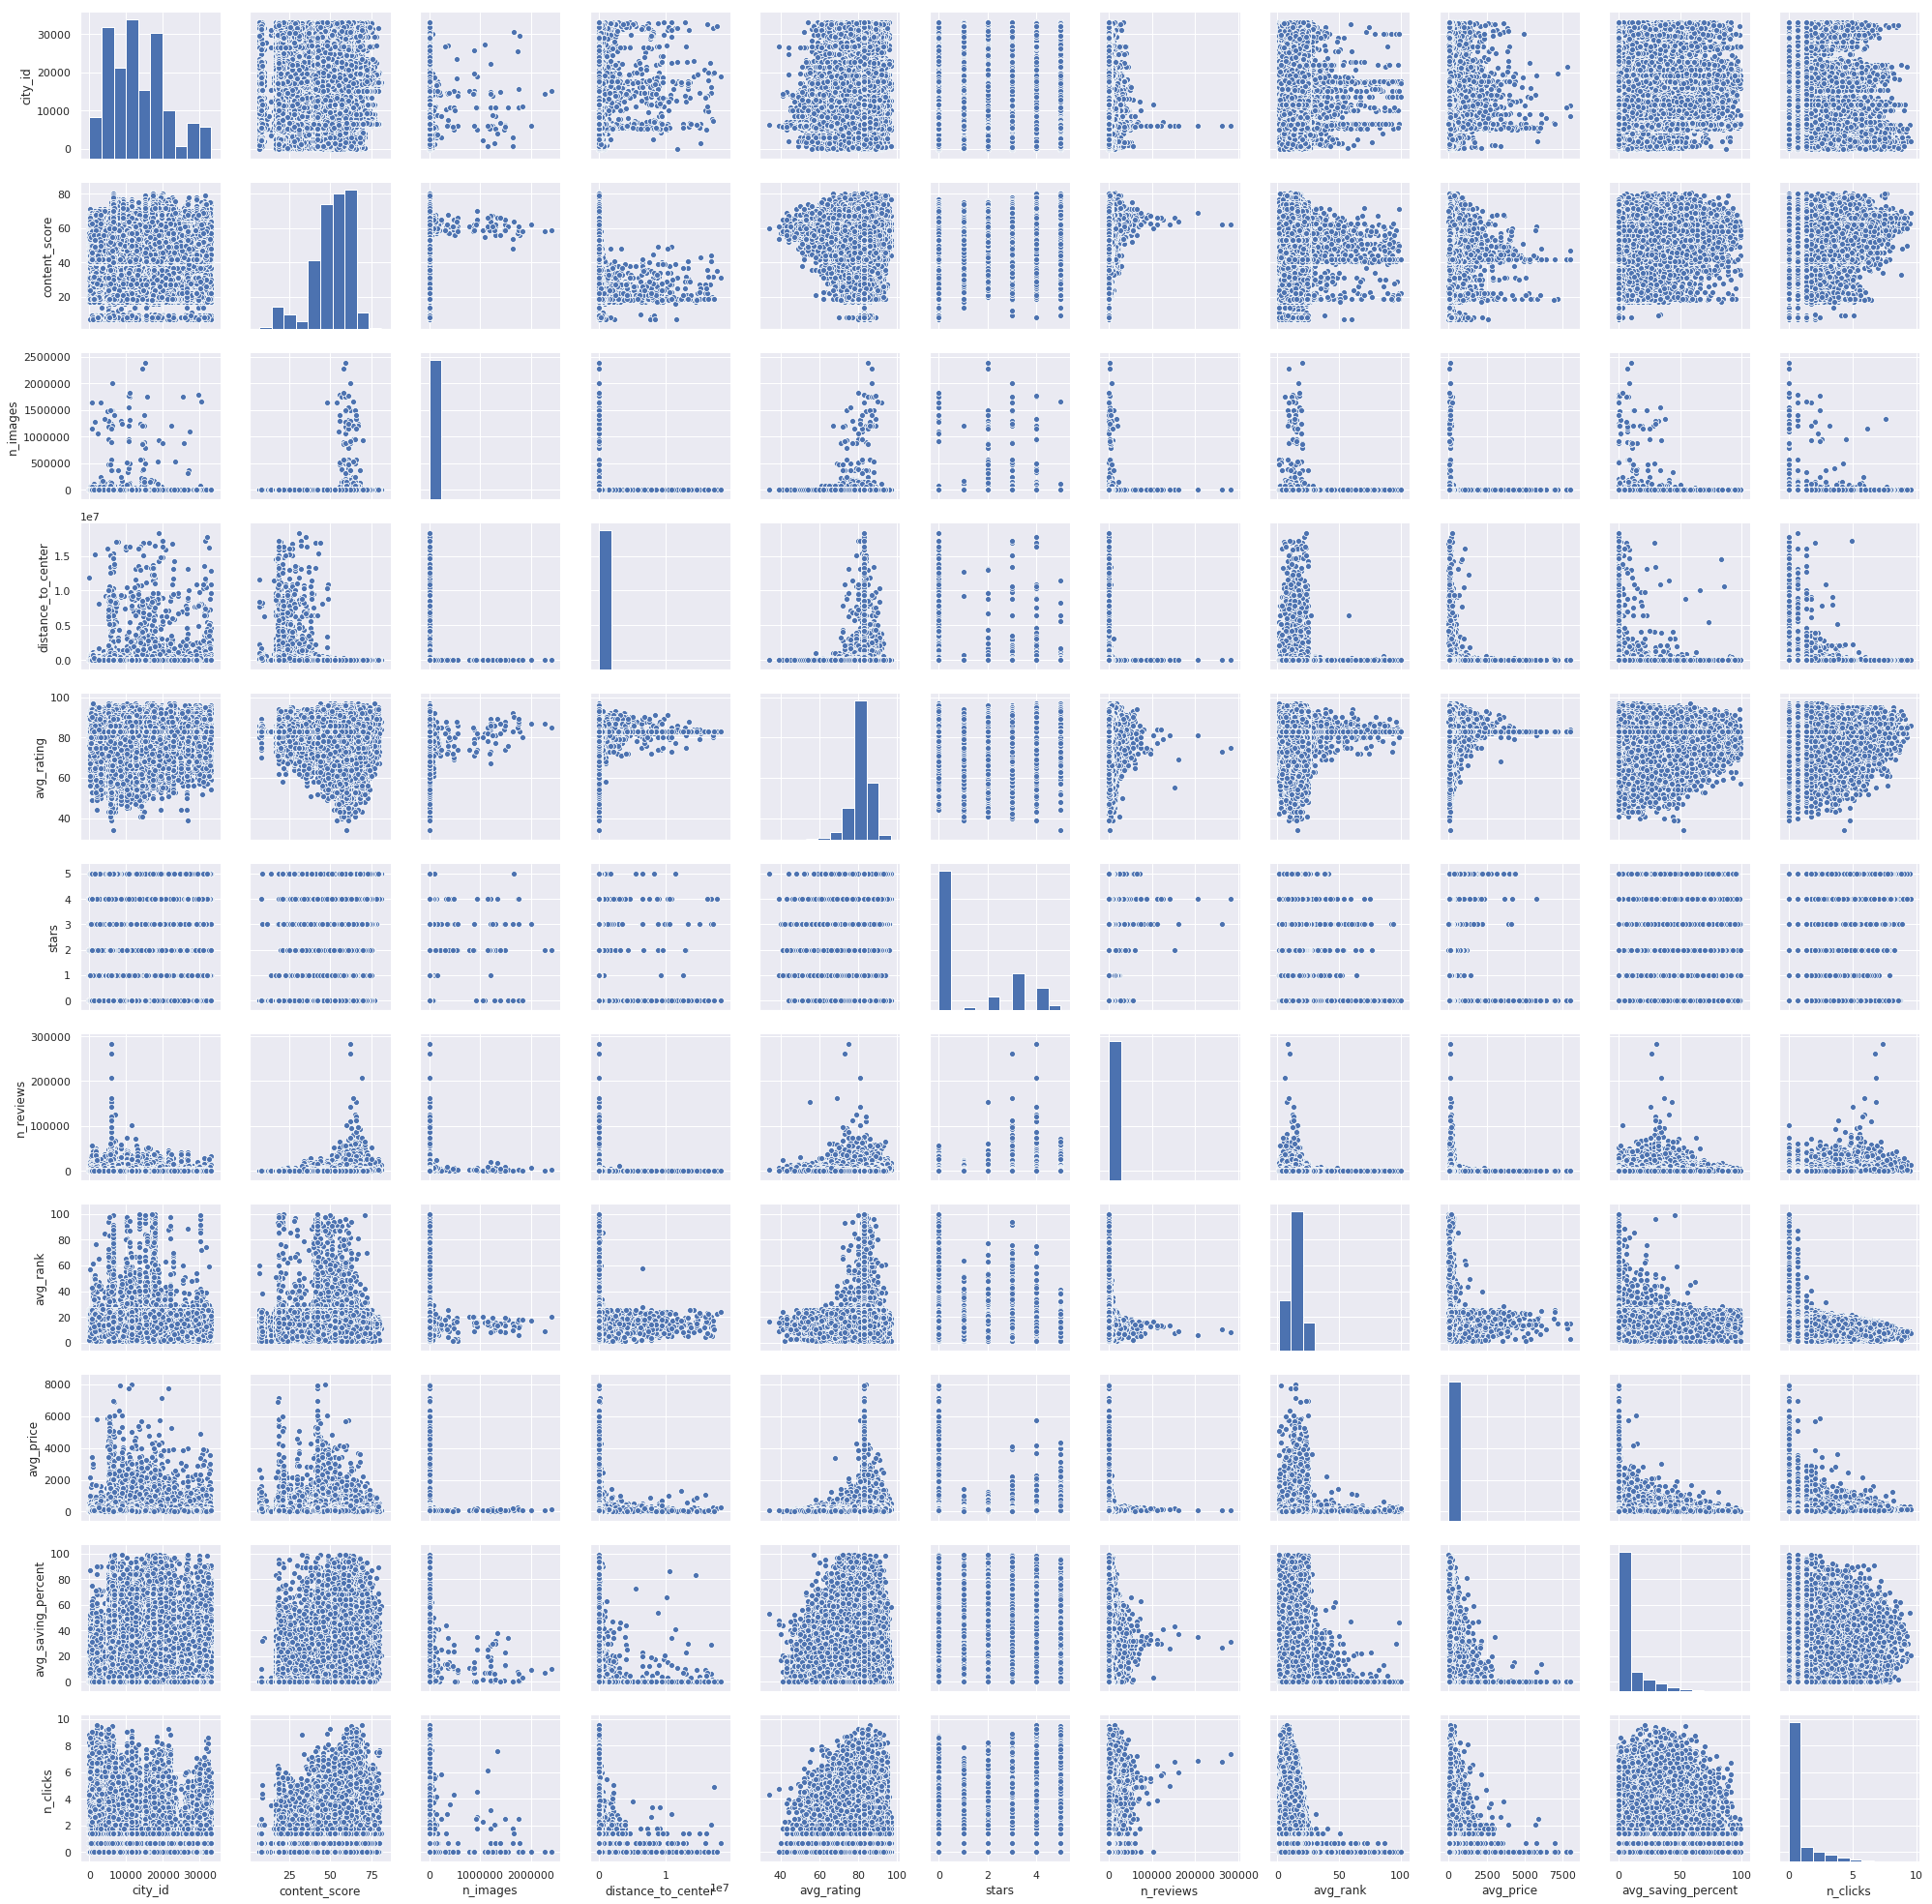

In [237]:
sns.set()
sns.pairplot(train_data, height = 2.5)
plt.show()

In [238]:
#Let's divide our data into test and validation set

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data.drop('n_clicks', axis =1), train_data.n_clicks,
                                                    train_size=0.8, random_state=42)

In case of random forest, we actually don't need to seperate into test and valid set, because Random forest keeps around 33% of data as OOB, OOB generally gives very accurate scores on unseen data.

In [239]:
X_train.head()

,city_id,content_score,n_images,distance_to_center,avg_rating,stars,n_reviews,avg_rank,avg_price,avg_saving_percent
1657,6633,61.0,1.0,4689.0,80.0,4.0,2739.0,9.500,46.08,6.0
249537,19124,51.0,0.0,709.0,83.0,2.0,0.0,11.000,42.95,0.0
182063,3466,48.0,1.0,482.0,84.0,0.0,219.0,20.654,82.15,0.0
382813,8996,43.0,0.0,2473.0,83.0,0.0,0.0,16.707,78.19,0.0
64442,644,50.0,0.0,112.0,80.0,3.0,564.0,12.721,75.16,0.0


In [240]:
#Not doing scaling in iteration 2

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# 5.) Explore many different models and shortlists the best ones.


In [241]:
# Establish model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, oob_score=True)

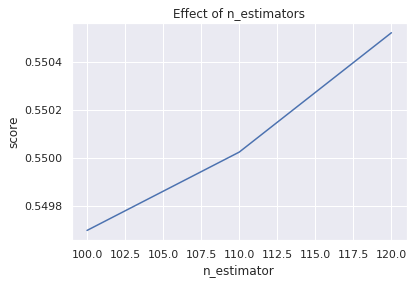

In [242]:
estimators = np.arange(100, 130, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n, random_state = 12345)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [243]:
scores

[0.5496988625346169, 0.5500245943002666, 0.550521015713228]

Okay, after 100 estimators there is no positive visible effect on the score. So we will use n_estimators at 60. 

Unfortunately, score is very low. What are we doing wrong? - ist iteration

In first iteration, the score was around 0.3, I took the log of n_clicks and ran the model again. R square on test data is now around 0.55 which is still not a very good explanation of variance for the data.

**Also, we need to think are we actually doing anything wrong or there is not enough data or target is actually dependent on some other variable as well which is not in our dataset**

In [244]:
#Okay, let's try dropping correlated variable and run for the same parameters to see if collinearity was casuing low score.
#This was again in iteration 1


#train_data_wc = X_train.drop(['content_score','avg_saving_percent'], axis=1)
#test_data_wc = X_test.drop(['content_score','avg_saving_percent'], axis=1)

In [245]:
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#print(train_data_wc.shape, y_train.shape, test_data_wc.shape, y_test.shape)

In [246]:
# estimators = np.arange(10, 100, 10)
# scores = []
# for n in estimators:
#     model.set_params(n_estimators=n, random_state = 12345)
#     model.fit(train_data_wc, y_train)
#     scores.append(model.score(test_data_wc, y_test))
# plt.title("Effect of n_estimators")
# plt.xlabel("n_estimator")
# plt.ylabel("score")
# plt.plot(estimators, scores)

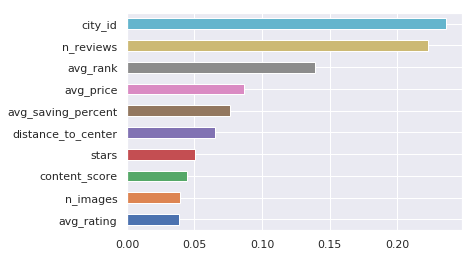

In [247]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nsmallest(10).plot(kind='barh')

In [248]:
#Let's define our evaluation metric function: weighted mean squared error.
import math
def wmse(x,y): 
    weights = np.log(y+1) + 1
    predminusobservered = weights*((x-y)**2)
    wmse = (np.sum(predminusobservered)/np.sum(weights))/y.count()
    return wmse

def print_score(m):
    res = [wmse(m.predict(X_train), y_train), wmse(m.predict(X_test), y_test)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [249]:
m = RandomForestRegressor(n_estimators=100, random_state=12345, oob_score=True)
%time m.fit(X_train, y_train)
%time print_score(m)

CPU times: user 4min 42s, sys: 120 ms, total: 4min 42s
Wall time: 4min 42s
[4.767075204518741e-07, 1.3516204684994576e-05, 0.5422392959242187]
CPU times: user 18.4 s, sys: 16 ms, total: 18.5 s
Wall time: 18.4 s


In [250]:
#Testing

# predicted_values = pd.DataFrame(m.predict(X_train)).reset_index().drop('index', axis = 1)
# actual_values = pd.DataFrame(y_train).reset_index().drop('index', axis =1)

# testing_output =pd.concat([predicted_values, actual_values], axis=1, keys=['Predicted_values', 'Actual_values'])

# testing_output.to_csv("Test_output.csv")

In [251]:
#Define cross Validation strategy.
#We can define rmse for now, low rmse means row wmse as well, because numerator is same for both the metric.
#Also, I don't know how to write your custom scoring method. 

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [252]:
#Modeling with 5 cross validation

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=100,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=100,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


model_GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_RForest = RandomForestRegressor(n_estimators=100, max_depth=8, max_features='auto',
                                   min_samples_leaf=4, random_state =5)


model_ExtraTree = ExtraTreesRegressor(n_estimators=100, max_depth=8, max_features='auto',
                                   min_samples_leaf=4, random_state =5)

In [253]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 1.1060 (0.0058)



In [254]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 1.1060 (0.0058)



In [255]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.9449 (0.0036)



In [256]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 1.0079 (0.0043)



In [257]:
score = rmsle_cv(model_GBoost)
print("Gradient Boost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Gradient Boost score: 0.9371 (0.0032)



In [258]:
score = rmsle_cv(model_RForest)
print("Random Forest score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Random Forest score: 0.9388 (0.0055)



In [259]:
score = rmsle_cv(model_ExtraTree)
print("Extra Tree score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

Extra Tree score: 0.9937 (0.0052)



The next step would be to do hyper parameter tuning using Gridsearch CV and find out best parameters for few of the selected model.

I am commenting this code because it takes hours to run.

In [260]:
# from sklearn.model_selection import GridSearchCV
# class grid():
#     def __init__(self,model):
#         self.model = model
    
#     def grid_get(self,X,y,param_grid):
#         grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
#         grid_search.fit(X,y)
#         print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
#         grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
#         print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])
        
        
# #RandomForest

# param_grid = { 'n_estimators': [20, 30, 40], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 'min_samples_leaf' : [3,4,5] }

# grid(RandomForestRegressor()).grid_get(X_train,y_train,param_grid)


# #GradientBoostRegressor

# param_grid={'n_estimators':[100, 200], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth':[4,6], 'min_samples_leaf':[3,5,9,17], 'max_features':[1.0,0.3,0.1] }

# grid(GradientBoostingRegressor()).grid_get(X_train,y_train,param_grid)

In [261]:
#I ran overnight for Random forest and got the following best tree combination for Random Forest

#{'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 40} 0.9163633553858429

# m = RandomForestRegressor(n_estimators=40, min_samples_leaf=4, max_features= 'auto', 
#                           n_jobs=-1, max_depth = 8,  random_state=123456, oob_score = True)
# %time m.fit(X_train, y_train)
# print_score(m)

## Stacking

Once we have best hyper parameters for few selected models, we can use the concept of stacking to get the best score.

# 6.) Fine tune your models and combine them into great solution

In [262]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [263]:
averaged_models = AveragingModels(models = (model_xgb, model_GBoost, model_RForest, model_ExtraTree))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.9382 (0.0038)



There are other ways of stacking also, where we can define our several base models.

* We can then divide our data into train and hold out samples.
* Then we will several models on train data
* And then test these base models on hold out samples.

Use the predictions from above) (called out-of-folds predictions) as the inputs, 
and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.


I won't be doing this for now. Instead I will be using our required metric and then predict through RandomForestRegressor which seems to be the best.

We can based on our different models can assign weight to them for the final predictions

# 7.) Present your solution.

We started our modeling for various scenarios:

* Without taking log of the target variable which is very skewed, we got a score b/w  0.29 to 0.35.
* Then we took the log of the target variable and for the same parameters for the random forest we got the score b/w 0.46 to 0.50
* Then we scaled our data and wanted to check if it effects the accuracy.  We got the same scores.
* We also checked that increasing the estimators any further doesn't have any effect on accuracy.
* We checked if there is any correlation b/w predictor variables and found out **content_score** and **avg_saving_percent**  are somewhat correlated with stars. We dropped them and check if there is any improvement in accuracy.  It actually lowers the scores.
* We then run different base models and found out few models with best accuracy.
* Grid Search CV was applied and we found the best parameters for selected models.
* Stacking and Ensemble Modelling should also be tried which I haven't done in this execrcise.

# Predicting on Test Set

Before we predict, we have to apply same transformations on test set except removing outliers. Because we need to predict on whole test data set.

In our case, we did touch only two features which needs to applied on test data set. In an ideal scenario, we should create functions so that we don't have to rewrite the whole code again.

In [264]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132162 entries, 0 to 132161
Data columns (total 11 columns):
hotel_id              132162 non-null int64
city_id               132007 non-null float64
content_score         132007 non-null float64
n_images              132006 non-null float64
distance_to_center    131999 non-null float64
avg_rating            95532 non-null float64
stars                 131987 non-null float64
n_reviews             131999 non-null float64
avg_rank              132162 non-null float64
avg_price             132104 non-null float64
avg_saving_percent    132104 non-null float64
dtypes: float64(10), int64(1)
memory usage: 11.1 MB


In [265]:
check_missing_data(test_data)

,Total,Percent
avg_rating,36630,27.715985
stars,175,0.132413
n_reviews,163,0.123333
distance_to_center,163,0.123333
n_images,156,0.118037
content_score,155,0.117280
city_id,155,0.117280
avg_saving_percent,58,0.043886
avg_price,58,0.043886
avg_rank,0,0.000000


In [266]:
#city_id

test_data.city_id = test_data.city_id.astype('category')
test_data['city_id'] = test_data['city_id'].astype('category').cat.codes

#n_images
test_data.n_images = test_data.n_images.replace(-1.0, np.nan)


In [267]:
#Apply same transformations on test data.

test_data = test_data.fillna(train_data.median())

In [268]:
check_missing_data(test_data)

,Total,Percent
avg_saving_percent,0,0.0
avg_price,0,0.0
avg_rank,0,0.0
n_reviews,0,0.0
stars,0,0.0
avg_rating,0,0.0
distance_to_center,0,0.0
n_images,0,0.0
content_score,0,0.0
city_id,0,0.0


In [ ]:
#We will fit on the whole training set.

model_GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

%time model_GBoost.fit(train_data.drop('n_clicks', axis=1), train_data.n_clicks)


submission = pd.DataFrame()

submission['hotel_id'] = test_data.hotel_id
submission['n_clicks'] = model_GBoost.predict(test_data.drop('hotel_id', axis =1))

submission.n_clicks = np.exp(submission.n_clicks)
print(submission.head())
print(submission.shape)
submission.to_csv('final_predictions.csv',index=False)

# Bonus Questions

**1.) Can you describe in your own words what the purpose of the evaluation metric above is? What alternative metrics would make sense in this context?**

In my opinion, the reason this metric is good is that target variable is highly skewed. If we take logs of the target variable and keep the weights as multiplier, we are in a way, normalize the data. 

Our data has more than 75% of n_clicks less than 2 clicks, so it make sense. I can think of 

**Root Mean Squared Logarithmic Error** as well for the same dataset. 
**Poisson Regression** - I have read poisson regression works well with skewed data. We need to check this.



**2.) We mention the click prediction as one component of our Exposure Algorithms. What other components would you include to determine what advertiser or hotel to show to our users?**

I am not exactly understanding the question here but here is what I am thinking: 

User information
Trip Purpose (Business/Liesure)
Days of travel (Weekends/Weekdays/Early year/Summer/Winter etc.)
Type of hotel (Business friendly, couple friendly, weekend getways etc)
Amenities in the hotel (I am more likely to select a hotel with better amenities like spa, swimming pool etc if they come at the same price)
Type of hotel - Hosted, A large chain.


**3.) Which of the input variables have a high predictive power? What additional variables would you include to reduce the error further?**

It looks like **city_id**, **number of reviews** and **rank** have high predective power. 

I would definitely try to include **user information** if we have ( this is tricky though because large number of users will be new), but if we have data for past bookings, we can get to know the price range of an user for example.

More hotel attribute will also help us. 


**4.) In addition to the model you used to calculate your results what are alternative models could you use for the prediction problem? What are trade-offs between the model you used and the alternatives?**

I used Gradient Boost Regressor, but I guess Random Forest should also work good.

The problem with Random forest is that they are easily overfitted.

The no free lunch theorem says there is no one better model than other, so in practice we should work on as many models as we can and then decide on the best one.